In [144]:
import numpy as np
import pandas as pd
import os

params = pd.read_csv('./params.txt', sep = " ", header=None).to_numpy()
num_exps_, num_params_ = params.shape 
params = params.tolist()
for i in range(num_exps_):
    for j in range(num_params_ ):
        if j == (num_params_ - 1):
            params[i][j] = str(int(params[i][j]))
        else:
            params[i][j] = f'{params[i][j]:.6f}'
params

[['1.500000', '0.026270', '0.500000', '0'],
 ['1.500000', '0.017512', '1.500000', '0'],
 ['1.500000', '0.014290', '2.500000', '0'],
 ['1.500000', '0.078809', '0.500000', '0'],
 ['1.500000', '0.052537', '1.500000', '0'],
 ['1.500000', '0.042869', '2.500000', '0'],
 ['1.500000', '0.210158', '0.500000', '0'],
 ['1.500000', '0.140098', '1.500000', '0'],
 ['1.500000', '0.114318', '2.500000', '0']]

In [145]:
orderings = ['random', 'morton',  'kdtree', 'hilbert'] #, 'mmd'
cs_set = [0, 10, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450]
bs_set = [20]
# cs_set = [30, 60]
# bs_set = [1]
filename_template = 'locs_20000_cs_{}_bs_{}_seed_0_kernel_{}:{}:{}_{}'
file_folder = './log/20k-kl/'
fig_folder = './fig/20k-kl/'

if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

# 20k
dense_llh = [-9089.455874354589468567, 15207.478328703782608500, 36435.962080644865636714, 
            1480.247069393142737681, 46689.730128752387827262, 88427.836103233014000580,
            11220.330297452925151447, 75865.277857565684826113, 136956.187419344205409288]

# classic vecchia 
classic_vecchia = np.asarray([[9.697091149901098106e-01,1.469962449846207164e-02],
    [2.502724138341909565e+01,8.085421669966308400e-01],
    [2.613471999053217587e+02,1.996535988397954497e+01],
    [2.341432298962672576e+00,8.454984691456957080e-02],
    [4.507013665924023371e+01,1.655010312060767319e+00],
    [4.892626140134816524e+02,3.950288067200744990e+01],
    [3.213716113392365514e+00,1.854145536362921121e-01],
    [5.284463768625573721e+01,2.066764691335265525e+00],
    [5.813322629081085324e+02,4.693584668502444401e+01]])

allh = np.zeros([num_exps_, len(orderings), len(cs_set), len(bs_set)])

for i_param, param in enumerate(params):
    for i_ord, ord in enumerate(orderings):
        for i_cs, cs in enumerate(cs_set):
            for i_bs, bs in enumerate(bs_set):
                filename = filename_template.format(cs, bs, param[0], param[1], param[2], ord)
                file_path = os.path.join(file_folder, filename)
                try:
                    with open(file_path, 'r') as file:
                        # Use a loop to skip the first line
                        file.readline()  # Read and discard the first line
                        # Now, read the second line
                        second_line = file.readline()
                        # print(dense_llh[i], float(second_line.split(",")[4]))
                        llh = dense_llh[i_param] - float(second_line.split(",")[4])
                        allh[i_param, i_ord, i_cs, i_bs] = llh
                except FileNotFoundError:
                    print(f"File {filename} not found")

allh.shape

(9, 4, 17, 1)

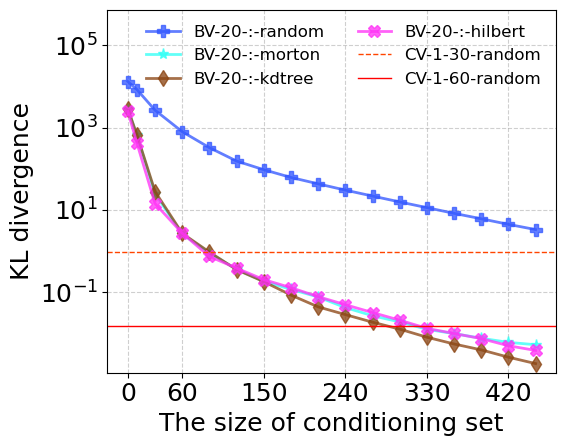

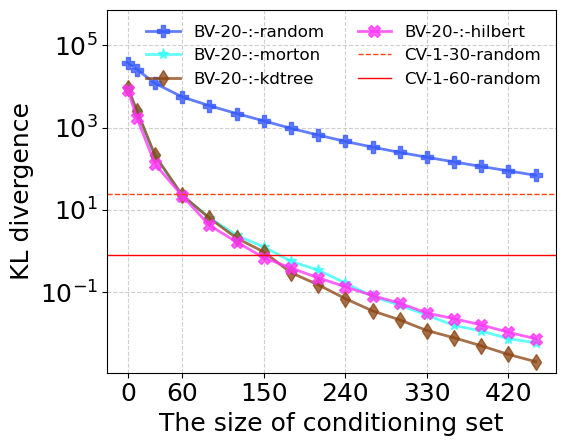

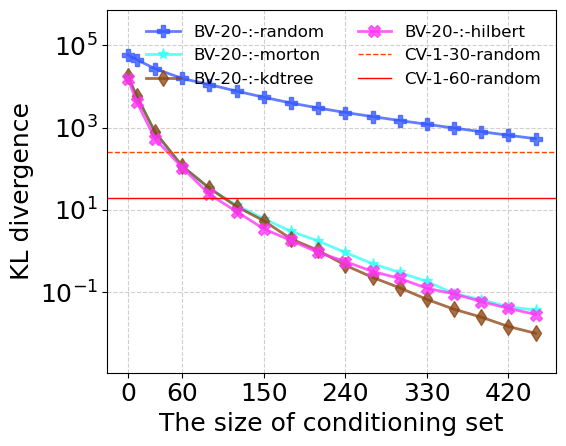

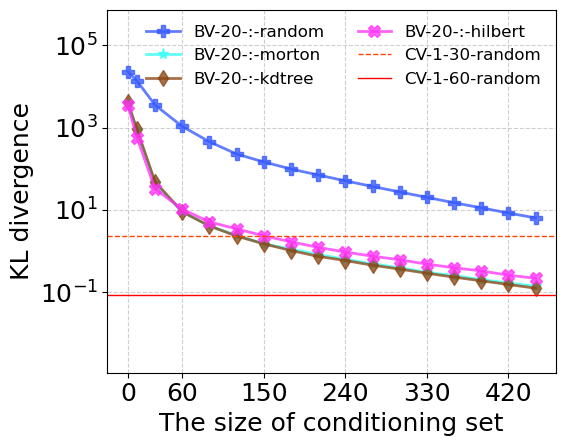

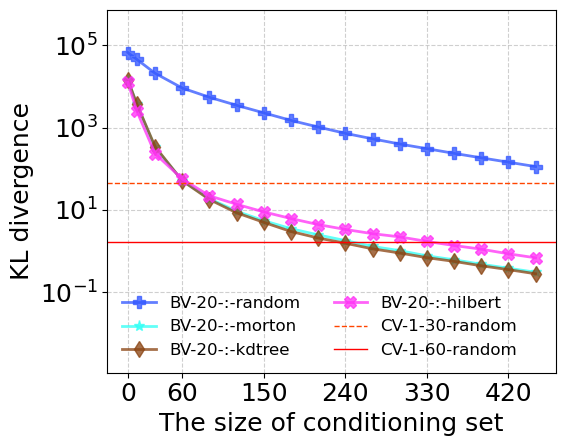

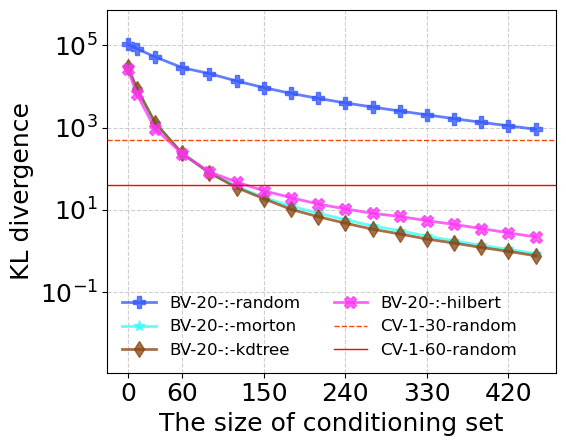

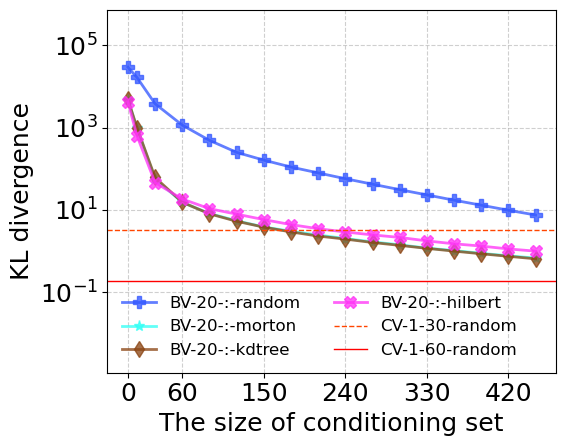

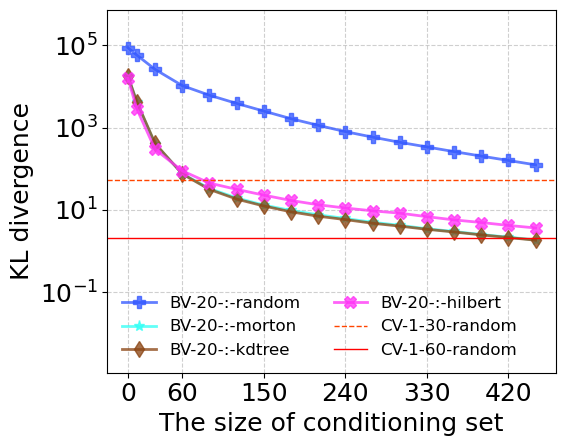

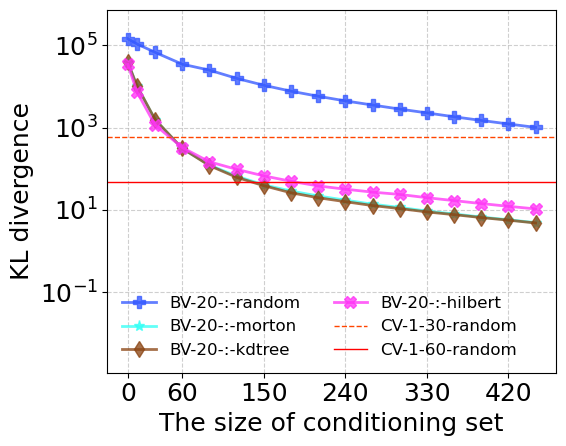

In [146]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.size'] = 18  # You can set any numeric value here

fig_dir = './fig'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

markers = ['P', '*', 'd', 'X', '8']
colors = [
    "#3357FF",  # Royal blue
    "#33FFF6",  # Cyan
    "#8B4513",  # Saddle brown
    "#FF33F6",  # Magenta
    "#F6FF33",  # Yellow
    "#FF5733",  # Reddish-orange
    "#33FF57",  # Bright green
    "#FF69B4",   # Hot pink
]
linestyles = ['-', '-.', '--']

ymax = np.max(allh)
ymin = np.min(allh)

def plot_kl(cs_set, bs_set, yy, info, i):
    fig, ax = plt.subplots(figsize=(6, 4.8))
    # fig, ax = plt.subplots(figsize=(6, 6))
    for i_ord, ord in enumerate(orderings):
        for i_bs, bs in enumerate(bs_set):
            ax.plot(cs_set, yy[i_ord, :, i_bs], label="BV-" + str(bs) + "-:-" + str(ord), 
                    linewidth=2, color=colors[i_ord], 
                    linestyle=linestyles[i_bs], alpha=0.77,
                    marker=markers[i_ord], markersize=8)
    # classic Vecchia - 30
    ax.axhline(y=classic_vecchia[i, 0], color='orangered', linestyle='--',
                linewidth=1.0, label='CV-1-30-random')
    # classic Vecchia - 60
    ax.axhline(y=classic_vecchia[i, 1], color='red', linestyle='-',
                linewidth=1.0, label='CV-1-60-random')
    ax.set_xlabel('The size of conditioning set')
    ax.set_ylabel('KL divergence')
    ax.set_ylim(ymin*0.6, ymax*5)
    ax.set_yscale('log')
    # if (info[1] == '0.114318'):
    # Adding enhanced legend, title, and labels
    legend = ax.legend(ncol = 2, fontsize=12)
                        # loc='lower center', bbox_to_anchor=(0.5, -0.5) 
                        # title = 'Conditioning size') #loc='lower center', bbox_to_anchor=(0.5, -0.3) 
    legend.get_frame().set_alpha(0.)  # 50% transparency
    # ax.legend(fontsize=12, shadow=True, frameon=True, ) #, title = 'Block size'
    ax.grid(True, linestyle='--', alpha=0.6)
    _list_xtick = cs_set[::3]
    plt.xticks(_list_xtick, _list_xtick)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_folder, f'{info[1]}_{info[2]}.pdf'))
    # plt.show()

for i in range(num_exps_):
    plot_kl(cs_set, bs_set, allh[i, :, :, :], params[i], i)